In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_features = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')
train_labels = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')
test_features = pd.read_csv('data/test_set_features.csv', index_col='respondent_id')

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
import xgboost as xgb

In [4]:
num_cols = train_features.select_dtypes("number").columns

cat_cols = [
    "race",
    "sex",
    "marital_status",
    "rent_or_own",
    "hhs_geo_region",
    "census_msa",
    "employment_industry",
    "employment_occupation",
]

ord_cols = ["age_group", "education", "income_poverty", "employment_status"]

assert len(num_cols) + len(cat_cols) + len(ord_cols) == train_features.shape[1]

In [5]:
def apply_preprocessor(preprocessor: ColumnTransformer, one_hot: bool):
    train_features_transformed = preprocessor.fit_transform(train_features)
    test_features_transformed = preprocessor.fit_transform(test_features)

    # Get feature names for transformed data
    if one_hot:
        cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols)
    else:
        cat_feature_names = np.array(cat_cols)
    ord_feature_names = np.array(ord_cols)

    # Combine all feature names into a single list
    all_feature_names = np.concatenate((num_cols, cat_feature_names, ord_feature_names))

    train_features_transformed_df = pd.DataFrame(train_features_transformed, columns=all_feature_names)
    test_features_transformed_df = pd.DataFrame(test_features_transformed, columns=all_feature_names)
    
    return train_features_transformed_df, test_features_transformed_df

In [6]:
def prepare_data_for_xgboost():
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
        ('scaler', MinMaxScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    ordinal_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('ordinal', OrdinalEncoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols),
            ('ord', ordinal_transformer, ord_cols)
        ]
    )
    
    return apply_preprocessor(preprocessor, True)

In [7]:
train_features_xgboost, test_features_xgboost = prepare_data_for_xgboost()
X_train_xgboost, X_test_xgboost, y_train, y_test = train_test_split(
    train_features_xgboost,
    train_labels,
    test_size=0.4,
    shuffle=True,
    random_state=314
)
X_train_xgboost

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,age_group,education,income_poverty,employment_status
19046,0.25,1.000000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,2.0,2.0
12518,0.50,0.666667,0.5,1.0,0.5,0.5,0.5,0.5,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,4.0,2.0
17641,0.75,0.666667,0.5,1.0,0.5,1.0,1.0,1.0,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,1.0,3.0
10337,0.75,0.333333,0.5,1.0,0.5,1.0,0.5,0.5,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0
5775,0.50,0.666667,0.5,0.5,0.5,1.0,0.5,0.5,1.0,0.5,...,0.0,0.0,0.0,0.0,1.0,0.0,5.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11094,0.75,0.666667,0.5,1.0,0.5,1.0,0.5,0.5,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,2.0
10163,0.50,0.666667,0.5,0.5,0.5,1.0,0.5,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,2.0,1.0
11977,0.25,1.000000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0
9837,1.00,1.000000,1.0,1.0,0.5,1.0,0.5,0.5,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,3.0,2.0


In [8]:
def prepare_data_for_catboost():
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ])

    ordinal_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('ordinal', OrdinalEncoder())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols),
            ('ord', ordinal_transformer, ord_cols)
        ]
    )
    
    return apply_preprocessor(preprocessor, False)

In [9]:
train_features_catboost, test_features_catboost = prepare_data_for_catboost()
X_train_catboost, X_test_catboost, y_train, y_test = train_test_split(
    train_features_catboost,
    train_labels,
    test_size=0.4,
    shuffle=True,
    random_state=314
)
X_train_catboost

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,marital_status,rent_or_own,hhs_geo_region,census_msa,employment_industry,employment_occupation,age_group,education,income_poverty,employment_status
19046,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Not Married,Rent,qufhixun,"MSA, Principle City",wxleyezf,emcorrxb,3,3,2,2
12518,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Married,Own,qufhixun,"MSA, Principle City",xicduogh,missing,5,2,4,2
17641,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,Not Married,Rent,bhuqouqj,"MSA, Principle City",missing,missing,5,3,1,3
10337,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,-1.0,...,Not Married,Own,lrircsnp,"MSA, Not Principle City",ldnlellj,mxkfnird,1,2,2,2
5775,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,Married,Own,qufhixun,"MSA, Not Principle City",atmlpfrs,xtkaffoo,5,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11094,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,Not Married,Rent,qufhixun,"MSA, Not Principle City",vjjrobsf,rcertsgn,3,1,1,2
10163,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-1.0,...,Not Married,Rent,lrircsnp,"MSA, Principle City",missing,missing,4,3,2,1
11977,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Not Married,Rent,lrircsnp,"MSA, Principle City",mcubkhph,vlluhbov,1,1,2,2
9837,3.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,Married,Own,bhuqouqj,"MSA, Not Principle City",fcxhlnwr,cmhcxjea,5,3,3,2


In [10]:
from typing import Literal, Any, Dict
from dataclasses import dataclass
from catboost import CatBoostClassifier


@dataclass
class TrainResult:
    model: Any
    scores: np.ndarray
    probabilities: np.ndarray
    y_test_target: pd.DataFrame


def train_model(target: Literal['h1n1_vaccine', 'seasonal_vaccine'], model_type: Literal['xgboost', 'catboost'], use_whole_dataset: bool = False, params: Dict = None) -> TrainResult:
    y_train_target = y_train[[target]]
    y_test_target = y_test[[target]]
    
    if model_type == 'xgboost':
        model = get_xgboost(params)
        X_train = X_train_xgboost
        X_test = X_test_xgboost
    if model_type == 'catboost':
        model = get_catboost(params)
        X_train = X_train_catboost
        X_test = X_test_catboost


    if use_whole_dataset:
        if model_type == 'xgboost':
            X_test = train_features_xgboost
        if model_type == 'catboost':
            X_test = train_features_catboost

    # Fit the model on the entire training set
    model.fit(X_train, y_train_target)

    # Predict probabilities for the TEST set
    y_probabilities = model.predict_proba(X_test)[:, 1]

    # Predict scores for TEST set
    y_predictions = model.predict(X_test)
    
    return TrainResult(
        model=model,
        scores=y_predictions,
        probabilities=y_probabilities,
        y_test_target=y_test_target
    )    
    
def get_xgboost(params: Dict = None):
    if params is None:
        params = {
            'colsample_bytree': 0.6, 
            'learning_rate': 0.01,
            'max_depth': 5,
            'n_estimators': 1000,
            'subsample': 0.3
        }
    
    return xgb.XGBClassifier(**params)

def get_catboost(params: Dict = None):
    if params is None:
        params = {
            'n_estimators': 1000,
            'max_depth': 5
        }
        
    return CatBoostClassifier(
        logging_level='Silent',
        cat_features=cat_cols,
        task_type='GPU',
        devices='0',
        **params
    )

In [11]:
from sklearn.metrics import roc_curve, auc


def process_result(result_h1n1: TrainResult, result_seasonal: TrainResult, model_type: Literal['xgboost', 'catboost'], axe: Any):
    fpr_h1n1, tpr_h1n1, _ = roc_curve(result_h1n1.y_test_target, result_h1n1.probabilities)
    fpr_seasonal, tpr_seasonal, _ = roc_curve(result_seasonal.y_test_target, result_seasonal.probabilities)
    
    roc_auc_h1n1 = auc(fpr_h1n1, tpr_h1n1)
    roc_auc_seasonal = auc(fpr_seasonal, tpr_seasonal)

    axe.plot(fpr_h1n1, tpr_h1n1, color='blue', label=f'H1N1 (AUC = {roc_auc_h1n1:.4f})')
    axe.plot(fpr_seasonal, tpr_seasonal, color='red', label=f'Seasonal (AUC = {roc_auc_seasonal:.4f})')
    axe.plot([0, 1], [0, 1], color='gray', linestyle='--')
    axe.set_xlabel('False Positive Rate')
    axe.set_ylabel('True Positive Rate')
    axe.set_title(f'ROC Curve for {model_type}')
    axe.legend(loc='lower right')
    axe.grid(True)
    
    return np.average([roc_auc_h1n1, roc_auc_seasonal])

In [12]:
def process_model(model_type: Literal['xgboost', 'catboost'], axe: Any, params: Dict = None) -> Any:
    result_h1n1 = train_model(
        target='h1n1_vaccine',
        model_type=model_type
    )
    result_seasonal = train_model(
        target='seasonal_vaccine',
        model_type=model_type
    )
    roc_auc = process_result(result_h1n1, result_seasonal, model_type, axe)
    
    print(f'Mean ROC AUC ({model_type}) = {roc_auc:.4f}')
    
    return {
        'h1n1_vaccine': result_h1n1.model,
        'seasonal_vaccine': result_seasonal.model
    }

Mean ROC AUC (xgboost) = 0.8650


CatBoostError: catboost/cuda/cuda_lib/cuda_base.h:281: CUDA error 35: CUDA driver version is insufficient for CUDA runtime version

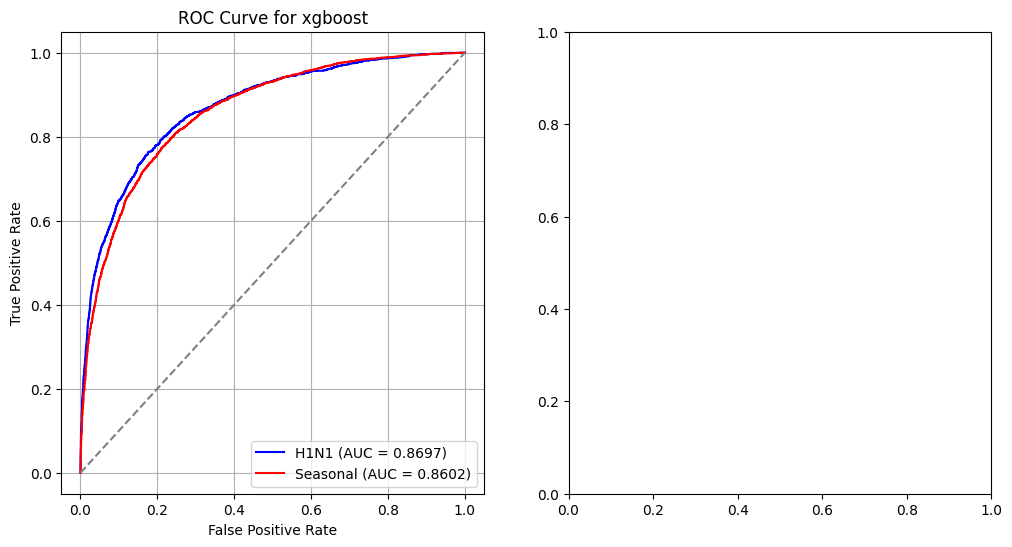

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

models_xgboost = process_model('xgboost', axes[0])
models_catboost = process_model('catboost', axes[1])

plt.tight_layout()
plt.show()

In [58]:
import optuna
from catboost import Pool, cv


def get_optimal_params_catboost(target: Literal['h1n1_vaccine', 'seasonal_vaccine']) -> Dict:
    cat_features_indices = list(range(23, 23 + len(cat_cols)))
    train_dataset = Pool(
        data=X_train_catboost,
        label=y_train[target],
        cat_features=cat_features_indices
    )
    
    def objective(trial):
        param = {
            'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
            'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
            'random_strength':trial.suggest_int("random_strength", 1,10),
            'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
            'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
            'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
            'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10),
            'od_type' : "Iter",
            'od_wait' : 100,
            "depth": trial.suggest_int("max_depth", 2,10),
            "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
            'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
            'custom_metric' : ['AUC'],
            "loss_function": "Logloss",
            'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

        scores = cv(train_dataset,
            param,
            fold_count=5, 
            early_stopping_rounds=10,
            plot=False, verbose=False
        )

        return scores['test-AUC-mean'].max()
    
    sampler = optuna.samplers.TPESampler(seed=68)  # Make the sampler behave in a deterministic way.
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=100)
    
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}={},".format(key, value))
    
    return trial.params

In [64]:
final_model = CatBoostClassifier(verbose=False, cat_features=cat_features_indices, **trial.params)
final_model.fit(X_train_catboost, y_train.h1n1_vaccine)

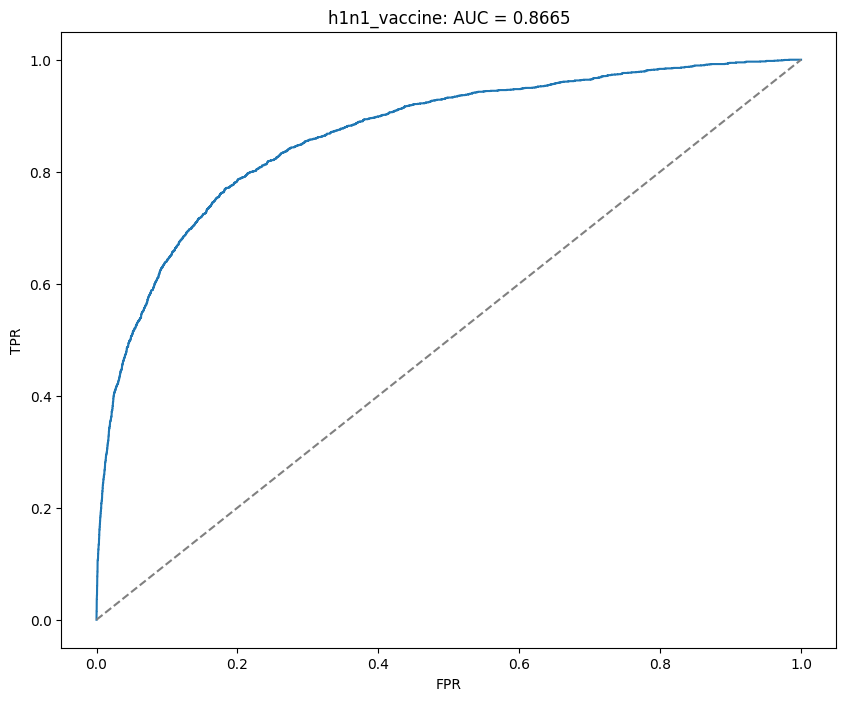

In [65]:
params_catboost_h1n1 = get_optimal_params_catboost(target='h1n1_vaccine')
params_catboost_seasonal = get_optimal_params_catboost(target='seasonal_vaccine')

result_h1n1_catboost_optimal = train_model(
    target='h1n1_vaccine',
    model_type='catboost'
)
result_seasonal_catboost_optimal = train_model(
    target='seasonal_vaccine',
    model_type='catboost'
)
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
roc_auc = process_result(result_h1n1_catboost_optimal, result_seasonal_catboost_optimal, 'catboost', axes[0])

print(f'Mean ROC AUC ({'catboost'}) = {roc_auc:.4f}')

plt.tight_layout()
plt.show()

In [ ]:
from datetime import datetime

def get_test_probabilities(model: Any) -> np.ndarray:
    return model.predict_proba(test_features_xgboost)[:, 1]

submission = pd.read_csv('data/submission_format.csv')

h1n1_model = train_model('h1n1_vaccine', 'xgboost', use_whole_dataset=True).model
seasonal_model = train_model('seasonal_vaccine', 'xgboost', use_whole_dataset=True).model

submission['h1n1_vaccine'] = get_test_probabilities(h1n1_model)
submission['seasonal_vaccine'] = get_test_probabilities(seasonal_model)

submission.to_csv(f'submission/submission_{datetime.now().isoformat(sep='_')}.csv', index=False)

submission

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.171270,0.349341
1,26708,0.021499,0.045364
2,26709,0.162811,0.352967
3,26710,0.515226,0.869933
4,26711,0.390040,0.538098
...,...,...,...
26703,53410,0.252479,0.597809
26704,53411,0.183881,0.282557
26705,53412,0.175007,0.274644
26706,53413,0.025884,0.225328
